In [92]:
import os
import sys
from glob import glob
import random
import string
import yaml
import pandas as pd
import root_pandas as rpd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
from collections import defaultdict
import ROOT
import copy
import tensorflow.keras
import tensorflow.saved_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Normalization
from tensorflow.keras.callbacks import Callback
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import plot_model
#from tensorflow.keras.utils.vis_utils import plot_model                                                                                                                
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import model_from_json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from pickle import dump
from lbn import LBN, LBNLayer
from tensorflow.keras.models import Model, model_from_json, load_model

In [93]:
# Load config
### open config.yaml and get all the necessary parameters
with open('config.yaml', 'r') as inf:
    config = yaml.safe_load(inf)
    
mainkeys    = list(config.keys())
tag         = config.get('Tag')
tagdir      = os.path.join(os.getcwd(),tag)

if not os.path.exists(tagdir):
    os.mkdir(tagdir)
else:
    print(f'{tagdir} already exists ...')

maintree       = config.get('intree')
infiledict     = config.get('infiles')
featuredict    = config.get('features')
featurelist    = list(featuredict.keys())
print(f'feature list : {featurelist}')
lbnfeaturelist = config.get('lbnfeatures')
print(f'lbn feature list : {lbnfeaturelist}')
signaldict     = infiledict.get('Signal')
backgrounddict = infiledict.get('Background')
scale          = config.get('DoScaling')
dotrain        = config.get('DoTrain')

modelparamdict = config.get('modelParams')
LayerDims   = modelparamdict.get('Layers')
IsBatchNorm = modelparamdict.get('BatchNorms')
DropOuts    = modelparamdict.get('Dropout')
L2regs      = modelparamdict.get('L2')
Activations = modelparamdict.get('activ')

trainingparamdict = config.get('trainingParams')
LossFunc = trainingparamdict.get('Loss')
LRate    = trainingparamdict.get('LR')
print(f'Learning rate : {LRate}')
Metrics  = trainingparamdict.get('Metrics')
valSplit = trainingparamdict.get('valSplit')
nEpoch   = trainingparamdict.get('epoch') 
opt      = tensorflow.keras.optimizers.Adam(learning_rate=LRate)
batchsize = trainingparamdict.get('BatchSize')

# Prepare train-test datasets (panda df)
### Use root_panda to get the event info from root files
############ plot function for input features ############
def plotinputfeatures(featurelist, tag=''):
    for feat in featurelist:
        feat_info = featuredict.get(feat)
        nbins  = feat_info[0]
        xlow   = feat_info[1]
        xhigh  = feat_info[2]
        nbins_ = np.linspace(xlow, xhigh, nbins)
        feat_sig = df_total_signal[feat].to_numpy()
        feat_bkg = df_total_background[feat].to_numpy()
        y_s,bins_s,patches_s = plt.hist(feat_sig,nbins_,density=True,histtype='bar',
                                        alpha=0.5,lw=2,log=False, label = 'Signal')
        y_b,bins_b,patches_b = plt.hist(feat_bkg,nbins_,density=True,histtype='bar',
                                        alpha=0.5,lw=2,log=False, label = 'Background')
    
        plt.xlabel(feat, fontsize=18)
        plt.ylabel('Normalised events', fontsize=18)
        plt.xticks(size = 18)
        plt.yticks(size = 18)
        plt.legend(loc='best', fontsize=16)
        plt.grid(True)
        
        plt.savefig(os.path.join(tagdir,feat+tag+'.png'), dpi=300)
        plt.show()
        plt.clf()
##########################################################
def PlotHistory(history):
    """ Takes history from Keras training and makes loss plots (batch and epoch) and learning rate plots """
    #----- Figure -----#
    variables = sorted([key for key in history.epochs.keys() if 'val' not in key and 'val_'+key in history.epochs.keys()])
    #variables += ["lr"]
    N = len(variables)
    fig, ax = plt.subplots(N,2,figsize=(12,N*2),sharex='col')
    plt.subplots_adjust(left    = 0.1,
                        right   = 0.6,
                        top     = 0.9,
                        bottom  = 0.1,
                        hspace  = 0.5,
                        wspace  = 0.4)
    
    #----- Batch Plots -----#
    for i,var in enumerate(variables):
        ax[i,0].plot(history.batches['batch'],history.batches[var],'k')
        ax[i,0].set_title(var)
        ax[i,0].set_xlabel('Batch')
        
    #----- Epoch Plots -----#
    for i,var in enumerate(variables):
        ax[i,1].plot(history.epochs['epoch'],history.epochs[var],label='train')
        if 'val_'+var in history.epochs.keys():
            ax[i,1].plot(history.epochs['epoch'],history.epochs['val_'+var],label='validation')
        ax[i,1].set_title(var)
        ax[i,1].legend()
        ax[i,1].set_xlabel('Epoch')

    # Save #
    rand_hash = ''.join(random.choice(string.ascii_uppercase) for _ in range(10)) # avoids overwritting
    png_name = 'Loss_%s.png'%rand_hash
    fig.savefig(os.path.join(tagdir,png_name), dpi=300)
    print('Curves saved as %s'%png_name)
#######################################################

feature list : ['pt_tauh1', 'met', 'pt_bjet1', 'pt_Xlep', 'pt_Wlep', 'vectorSumpt_XlwpWlep', 'dr_XlepWlep', 'dphi_Wleptauh', 'dphi_Wlepbjet', 'HT_Jets', 'dr_min_Xlepjets', 'dr_min_Wlepjets', 'dphi_Xleptauh', 'effectiveMass', 'dr_min_jets', 'mt_Wlepmet', 'dphi_Xlepmet', 'dphi_Wlepmet', 'dphi_bjetljet']
lbn feature list : ['px_tauh1', 'py_tauh1', 'pz_tauh1', 'energy_tauh1', 'px_bjet1', 'py_bjet1', 'pz_bjet1', 'energy_bjet1', 'px_ljet1', 'py_ljet1', 'pz_ljet1', 'energy_ljet1', 'px_Xlep', 'py_Xlep', 'pz_Xlep', 'energy_Xlep', 'px_Wlep', 'py_Wlep', 'pz_Wlep', 'energy_Wlep', 'px_met', 'py_met', 'pz_met', 'energy_met']
Learning rate : 0.01


In [94]:
signal_info_list     = list(signaldict.values())
background_info_list = list(backgrounddict.values())

print(signal_info_list)
print(background_info_list)

dfs_signal     = []
dfs_background = []
for item in signal_info_list:
    path   = item[0]
    clswt  = item[1] # xsec
    dfitem = rpd.read_root(path, key=maintree)[featurelist+lbnfeaturelist]
    dfitem['tag'] = 1
    dfs_signal.append(dfitem)

for item in background_info_list:
    path  = item[0]
    clswt = item[1] # xsec
    dfitem = rpd.read_root(path, key=maintree)[featurelist+lbnfeaturelist]
    dfitem['tag'] = 0
    dfs_background.append(dfitem)

print(f'No of signal processes : {len(dfs_signal)}, bkg processes : {len(dfs_background)}')

df_total_signal = pd.concat(dfs_signal) # panda df for all signals
df_total_background = pd.concat(dfs_background) # panda df for all backgrounds

#plotinputfeatures(featurelist, tag='_raw')

sigtrain,  sigtest  = train_test_split(dfs_signal[0],     test_size=0.2, random_state=42, shuffle=True)
bkg1train, bkg1test = train_test_split(dfs_background[0], test_size=0.2, random_state=42, shuffle=True)
bkg2train, bkg2test = train_test_split(dfs_background[1], test_size=0.2, random_state=42, shuffle=True)
bkg3train, bkg3test = train_test_split(dfs_background[2], test_size=0.2, random_state=42, shuffle=True)

df_train = pd.concat([sigtrain,bkg1train,bkg2train,bkg3train])
df_train.sample(frac=1)
df_test  = pd.concat([sigtest,bkg1test,bkg2test,bkg3test])
df_test.sample(frac=1)

df_train_only, df_val = train_test_split(df_train, test_size=0.2, random_state=42, shuffle=True)

# Prepare train and test datasets
np_train = df_train_only.to_numpy()
np_val   = df_val.to_numpy()
np_test  = df_test.to_numpy()

x_train = np_train[:,:np_train.shape[1]-1]
y_train = np_train[:,-1].reshape(-1,1)
y_train = to_categorical(y_train, 2)

x_val   = np_val[:,:np_train.shape[1]-1]
y_val   = np_val[:,-1].reshape(-1,1)
y_val   = to_categorical(y_val, 2)

x_test  = np_test[:,:np_test.shape[1]-1]
y_test  = np_test[:,-1].reshape(-1,1)
y_test  = to_categorical(y_test, 2)

print(f'Shape of x_test : {x_test.shape}')

print(f'Train --> Sig : {np.sum(y_train > 0)}   Bkg : {np.sum(y_train < 1)}')
print(f'Test  --> Sig : {np.sum(y_test > 0)}    Bkg : {np.sum(y_test < 1)}')

#x_train_lbn = x_train[:,-len(lbnfeaturelist):].reshape(-1,4,len(lbnfeaturelist)//4)
#x_train_dnn = x_train[:,:-len(lbnfeaturelist)]
#x_val_lbn   = x_val[:,-len(lbnfeaturelist):].reshape(-1,4,len(lbnfeaturelist)//4)
#x_val_dnn   = x_val[:,:-len(lbnfeaturelist)]
x_train_lbn = x_train[:,-len(lbnfeaturelist):].reshape(-1,len(lbnfeaturelist)//4,4)
x_train_dnn = x_train[:,:-len(lbnfeaturelist)]
x_val_lbn   = x_val[:,-len(lbnfeaturelist):].reshape(-1,len(lbnfeaturelist)//4,4)
x_val_dnn   = x_val[:,:-len(lbnfeaturelist)]
x_test_lbn  = x_test[:,-len(lbnfeaturelist):].reshape(-1,len(lbnfeaturelist)//4,4)
x_test_dnn  = x_test[:,:-len(lbnfeaturelist)]
print(f'shape of x_train_lbn : {x_train_lbn.shape}')
print(f'shape of x_val_lbn   : {x_val_lbn.shape}')
print(f'shape of x_train_dnn : {x_train_dnn.shape}')
print(f'shape of x_val_dnn   : {x_val_dnn.shape}')

[['/home/gsaha/Work/DelphesAnalysis_Project2/JobOutput_XmutauWlnu_ChiMass_60/Signal_xmutau_Wlnu_mvaIn_mx60_mutap01_ctp01.root', 0.05, 400000, 'signal']]
[['/home/gsaha/Work/DelphesAnalysis_Project2/JobOutput_XmutauWlnu_ChiMass_60/TTJets_DiLep_mvaIn.root', 109.8, 10855428, 'TT + Jets'], ['/home/gsaha/Work/DelphesAnalysis_Project2/JobOutput_XmutauWlnu_ChiMass_60/TTWJetsToLNu_mvaIn.root', 0.25, 4765526, 'TTV + Jets'], ['/home/gsaha/Work/DelphesAnalysis_Project2/JobOutput_XmutauWlnu_ChiMass_60/TTZJetsToLL_mvaIn.root', 0.24, 2584012, 'TTV + Jets']]
No of signal processes : 1, bkg processes : 3
Shape of x_test : (17145, 43)
Train --> Sig : 54854   Bkg : 54854
Test  --> Sig : 17145    Bkg : 17145
shape of x_train_lbn : (54854, 6, 4)
shape of x_val_lbn   : (13714, 6, 4)
shape of x_train_dnn : (54854, 19)
shape of x_val_dnn   : (13714, 19)


In [109]:
featlayer_all = []
for feat in featurelist:    
    #featname = featurelist[idx]
    input_layer = tensorflow.keras.Input(shape=(1,), name=feat)
    #print(f'input shape : {input_layer.shape}')
    featlayer_all.append(input_layer)
    
all_features = tensorflow.keras.layers.concatenate(featlayer_all,axis=-1,name="Features")
print(f'type & shape of concatenated input features : {type(all_features)}, {all_features.shape}')

#print(x_train_lbn.shape[1:])
input_lbn_Layer = tensorflow.keras.Input(shape=x_train_lbn.shape[1:],name='LBN_inputs')
print(f'type & shape of lbn input: {type(input_lbn_Layer)}, {input_lbn_Layer.shape}')

lbn_layer_ = LBNLayer(x_train_lbn.shape[1:], 
                      n_particles = 25,
                      boost_mode  = LBN.PAIRS, 
                      #features    = ["E", "px", "py", "pz", "pt", "p", "m", "pair_cos"],
                      features    = ["E","px","py","pz","pt","p","m","phi","eta","beta","gamma","pair_cos","pair_dr","pair_ds","pair_dy"],
                      name='LBN')
print(f'Type & shape of LBN layer : {type(lbn_layer_)}')
lbn_layer = lbn_layer_(input_lbn_Layer)
print(f'Type & shape of LBN layer with keras tensor : {type(lbn_layer)}, {lbn_layer.shape}')

batchnorm_ = tensorflow.keras.layers.BatchNormalization(name='batchnorm')
print(f'type &shape of batchnorm_ : {type(batchnorm_)}')
batchnorm = batchnorm_(lbn_layer)
print(f'type & shape of batchnorm : {type(batchnorm)}, {batchnorm.shape}')

concatenate = tensorflow.keras.layers.Concatenate(axis=-1)([all_features, batchnorm])
print(f'Concatenated shape : {concatenate.shape}')


L1 = Dense(512, input_dim=len(featurelist), activation='relu', 
           kernel_regularizer=regularizers.l2(0.001))(all_features) #(concatenate) #all_features
L1 = Dropout(0.5)(L1)
L2 = Dense(128, activation='relu', 
           kernel_regularizer=regularizers.l2(0.001))(L1)
L2 = Dropout(0.5)(L2)
L3 = Dense(64, activation='relu', 
           kernel_regularizer=regularizers.l2(0.001))(L2)
L4 = Dense(12, activation='relu', 
           kernel_regularizer=regularizers.l2(0.001))(L3)

output = Dense(2, activation='softmax')(L4)

#model = tensorflow.keras.Model(all_inputs, output)

# Define model #
model_inputs = [featlayer_all]
model_inputs.append(input_lbn_Layer)
model = Model(inputs=model_inputs, outputs=[output])
model.summary()

type & shape of concatenated input features : <class 'keras.engine.keras_tensor.KerasTensor'>, (None, 19)
type & shape of lbn input: <class 'keras.engine.keras_tensor.KerasTensor'>, (None, 6, 4)
Type & shape of LBN layer : <class 'lbn.LBNLayer'>
Type & shape of LBN layer with keras tensor : <class 'keras.engine.keras_tensor.KerasTensor'>, (None, 1475)
type &shape of batchnorm_ : <class 'keras.layers.normalization.batch_normalization.BatchNormalization'>
type & shape of batchnorm : <class 'keras.engine.keras_tensor.KerasTensor'>, (None, 1475)
Concatenated shape : (None, 1494)
Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
pt_tauh1 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
met 

In [110]:
# Compile and fit
#set early stopping monitor so the model stops training when it won't improve anymore                                                                     
#early_stopping_monitor = EarlyStopping(patience=3)                                                                                                       
# https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd                                              
custom_early_stopping = EarlyStopping(
    monitor='val_loss',
    #monitor='loss',
    #patience=int(nEpoch/10),
    patience=20,                                                                                                                                         
    min_delta=0.0001,
    verbose=1,
    restore_best_weights=True,
    #restore_best_weights=False,                                                                                                                          
    mode='min'
    #mode='max'                                                                                                                                           
)
#https://keras.io/api/callbacks/reduce_lr_on_plateau/                                                                                                     
custom_ReduceLROnPlateau = ReduceLROnPlateau(
    monitor="val_loss",
    #monitor="loss",                                                                                                                  
    factor=0.5, #0.1
    #patience=5,                                                                                                                                          
    patience=10,
    verbose=1,
    mode="min",
    #mode="max",                                                                                                                                          
    cooldown=0,                                                                                                                                          
    #cooldown=5,
    #min_lr=0
    min_lr=1e-5,                                                                                                                                         
    min_delta=0.0001                                                                                                                                      
)
#custom loss-history with batch
#https://github.com/cp3-llbb/HHbbWWAnalysis/blob/master/MachineLearning/HHMachineLearning/Model.py#L47
class LossHistory(Callback):
    """ Records the history of the training per epoch and per batch """
    def on_train_begin(self, logs={}):
        self.epochs  = defaultdict(list) 
        self.batches = defaultdict(list) 
        self.pre_batch = 0

    def on_batch_end(self, batch, logs={}):
        self.batches['batch'].append(batch+self.pre_batch)
        for key,val in logs.items():
            self.batches[key].append(val)
        self.batches['lr'].append(tensorflow.keras.backend.eval(self.model.optimizer.lr))
        #loss = logs.get('loss')
        #print(f'\nBatch : {batch} with average loss : {loss}')

    def on_epoch_end(self, epoch, logs={}):
        self.epochs['epoch'].append(epoch)
        for key,val in logs.items():
            self.epochs[key].append(val)
        self.epochs['lr'].append(tensorflow.keras.backend.eval(self.model.optimizer.lr))
        self.pre_batch = self.batches['batch'][-1] 

loss_history = LossHistory()
model.compile(loss=LossFunc, 
              optimizer=opt, 
              metrics=[tensorflow.keras.metrics.CategoricalAccuracy(),
                       tensorflow.keras.metrics.AUC(),
                       tensorflow.keras.metrics.Precision(),
                       tensorflow.keras.metrics.Recall()])

callback_list = [custom_early_stopping, custom_ReduceLROnPlateau, loss_history]
#callback_list = [loss_history]

fit_inputs = np.hsplit(x_train,x_train.shape[1])
print(x_train.shape[1])
#fit_inputs = np.hsplit(x_train,len(featurelist))
fit_val    = (np.hsplit(x_val,x_val.shape[1]),y_val)
fit_inputs.append(x_train_lbn)
fit_val[0].append(x_val_lbn)

#model.summary()
print(len(fit_inputs))
print(x_train.shape, y_train.shape, x_val.shape)

history = model.fit(fit_inputs, 
                    y_train, 
                    epochs=nEpoch, 
                    batch_size=batchsize, 
                    #validation_split=valSplit,
                    validation_data = fit_val,
                    verbose=1, 
                    #class_weight=None, 
                    use_multiprocessing=True,
                    callbacks=callback_list)


43
44
(54854, 43) (54854, 2) (13714, 43)
Epoch 1/1000
28/28 [==============================] - 2s 35ms/step - loss: 4.8714 - categorical_accuracy: 0.6651 - auc_10: 0.6860 - precision_10: 0.6651 - recall_10: 0.6651 - val_loss: 0.8811 - val_categorical_accuracy: 0.7349 - val_auc_10: 0.7943 - val_precision_10: 0.7349 - val_recall_10: 0.7349
Epoch 2/1000
28/28 [==============================] - 0s 16ms/step - loss: 1.0387 - categorical_accuracy: 0.7081 - auc_10: 0.7361 - precision_10: 0.7081 - recall_10: 0.7081 - val_loss: 0.9330 - val_categorical_accuracy: 0.7398 - val_auc_10: 0.8069 - val_precision_10: 0.7398 - val_recall_10: 0.7398
Epoch 3/1000
28/28 [==============================] - 0s 17ms/step - loss: 0.9030 - categorical_accuracy: 0.7296 - auc_10: 0.7601 - precision_10: 0.7296 - recall_10: 0.7296 - val_loss: 0.8608 - val_categorical_accuracy: 0.7398 - val_auc_10: 0.7833 - val_precision_10: 0.7398 - val_recall_10: 0.7398
Epoch 4/1000
28/28 [==============================] - 1s 18ms/

Epoch 25/1000
28/28 [==============================] - 1s 18ms/step - loss: 0.7331 - categorical_accuracy: 0.7383 - auc_10: 0.8126 - precision_10: 0.7383 - recall_10: 0.7383 - val_loss: 0.7556 - val_categorical_accuracy: 0.7398 - val_auc_10: 0.8280 - val_precision_10: 0.7398 - val_recall_10: 0.7398
Epoch 26/1000
28/28 [==============================] - 1s 19ms/step - loss: 0.7323 - categorical_accuracy: 0.7383 - auc_10: 0.8127 - precision_10: 0.7383 - recall_10: 0.7383 - val_loss: 0.7479 - val_categorical_accuracy: 0.7398 - val_auc_10: 0.8285 - val_precision_10: 0.7398 - val_recall_10: 0.7398
Epoch 27/1000
28/28 [==============================] - 0s 18ms/step - loss: 0.7285 - categorical_accuracy: 0.7383 - auc_10: 0.8137 - precision_10: 0.7383 - recall_10: 0.7383 - val_loss: 0.7550 - val_categorical_accuracy: 0.7398 - val_auc_10: 0.8286 - val_precision_10: 0.7398 - val_recall_10: 0.7398
Epoch 28/1000
28/28 [==============================] - 1s 19ms/step - loss: 0.7265 - categorical_acc

28/28 [==============================] - 1s 20ms/step - loss: 0.6509 - categorical_accuracy: 0.7378 - auc_10: 0.8254 - precision_10: 0.7378 - recall_10: 0.7378 - val_loss: 0.6936 - val_categorical_accuracy: 0.7538 - val_auc_10: 0.8338 - val_precision_10: 0.7538 - val_recall_10: 0.7538
Epoch 80/1000
28/28 [==============================] - 1s 20ms/step - loss: 0.6494 - categorical_accuracy: 0.7395 - auc_10: 0.8258 - precision_10: 0.7395 - recall_10: 0.7395 - val_loss: 0.6828 - val_categorical_accuracy: 0.7538 - val_auc_10: 0.8338 - val_precision_10: 0.7538 - val_recall_10: 0.7538
Epoch 81/1000
28/28 [==============================] - 1s 20ms/step - loss: 0.6491 - categorical_accuracy: 0.7386 - auc_10: 0.8251 - precision_10: 0.7386 - recall_10: 0.7386 - val_loss: 0.6950 - val_categorical_accuracy: 0.7546 - val_auc_10: 0.8340 - val_precision_10: 0.7546 - val_recall_10: 0.7546
Epoch 82/1000
28/28 [==============================] - 1s 18ms/step - loss: 0.6472 - categorical_accuracy: 0.7391 

28/28 [==============================] - 1s 18ms/step - loss: 0.6115 - categorical_accuracy: 0.7433 - auc_10: 0.8295 - precision_10: 0.7433 - recall_10: 0.7433 - val_loss: 0.6759 - val_categorical_accuracy: 0.7505 - val_auc_10: 0.8353 - val_precision_10: 0.7505 - val_recall_10: 0.7505
Epoch 134/1000
28/28 [==============================] - 1s 20ms/step - loss: 0.6103 - categorical_accuracy: 0.7442 - auc_10: 0.8303 - precision_10: 0.7442 - recall_10: 0.7442 - val_loss: 0.6790 - val_categorical_accuracy: 0.7473 - val_auc_10: 0.8339 - val_precision_10: 0.7473 - val_recall_10: 0.7473
Epoch 135/1000
28/28 [==============================] - 1s 19ms/step - loss: 0.6099 - categorical_accuracy: 0.7434 - auc_10: 0.8298 - precision_10: 0.7434 - recall_10: 0.7434 - val_loss: 0.6763 - val_categorical_accuracy: 0.7492 - val_auc_10: 0.8345 - val_precision_10: 0.7492 - val_recall_10: 0.7492
Epoch 136/1000
28/28 [==============================] - 1s 19ms/step - loss: 0.6097 - categorical_accuracy: 0.74

Epoch 160/1000
28/28 [==============================] - 0s 17ms/step - loss: 0.5955 - categorical_accuracy: 0.7445 - auc_10: 0.8314 - precision_10: 0.7445 - recall_10: 0.7445 - val_loss: 0.6645 - val_categorical_accuracy: 0.7460 - val_auc_10: 0.8327 - val_precision_10: 0.7460 - val_recall_10: 0.7460
Epoch 161/1000
28/28 [==============================] - 0s 17ms/step - loss: 0.5947 - categorical_accuracy: 0.7445 - auc_10: 0.8317 - precision_10: 0.7445 - recall_10: 0.7445 - val_loss: 0.6698 - val_categorical_accuracy: 0.7414 - val_auc_10: 0.8300 - val_precision_10: 0.7414 - val_recall_10: 0.7414
Epoch 162/1000
28/28 [==============================] - 0s 16ms/step - loss: 0.5947 - categorical_accuracy: 0.7458 - auc_10: 0.8316 - precision_10: 0.7458 - recall_10: 0.7458 - val_loss: 0.6626 - val_categorical_accuracy: 0.7476 - val_auc_10: 0.8335 - val_precision_10: 0.7476 - val_recall_10: 0.7476
Epoch 163/1000
28/28 [==============================] - 0s 17ms/step - loss: 0.5950 - categorical

Curves saved as Loss_GYSWNHOQFD.png
dict_keys(['loss', 'categorical_accuracy', 'auc_9', 'precision_9', 'recall_9', 'val_loss', 'val_categorical_accuracy', 'val_auc_9', 'val_precision_9', 'val_recall_9', 'lr'])


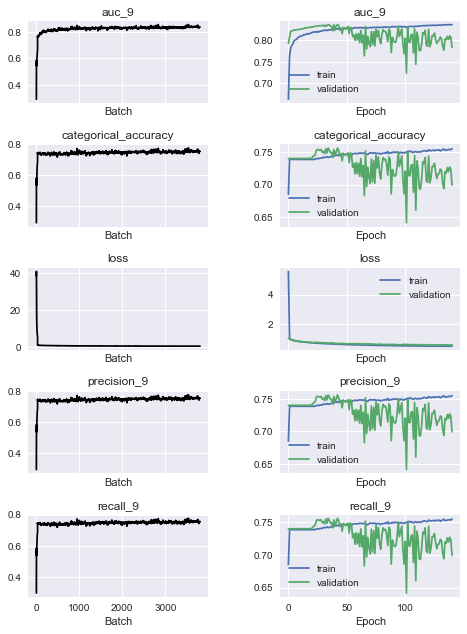

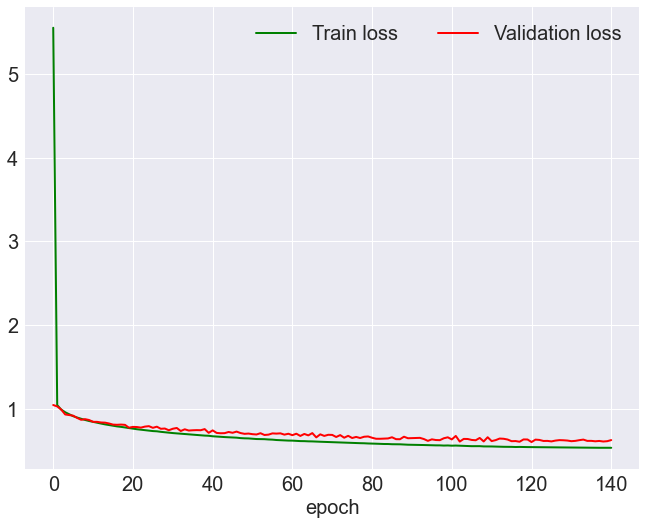

<Figure size 576x396 with 0 Axes>

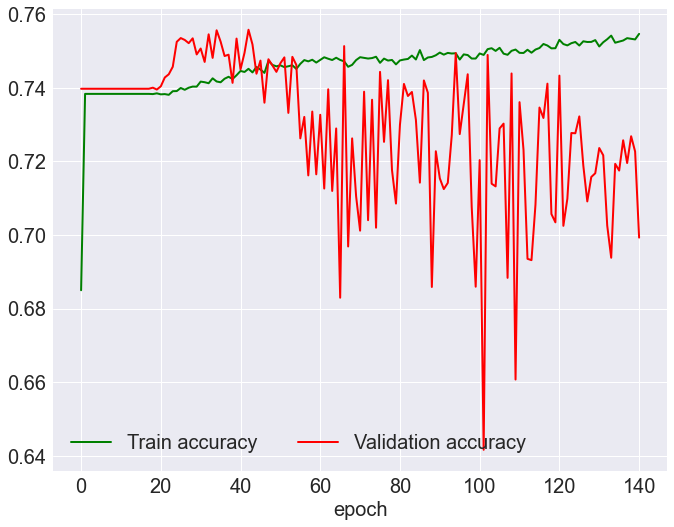

<Figure size 576x396 with 0 Axes>

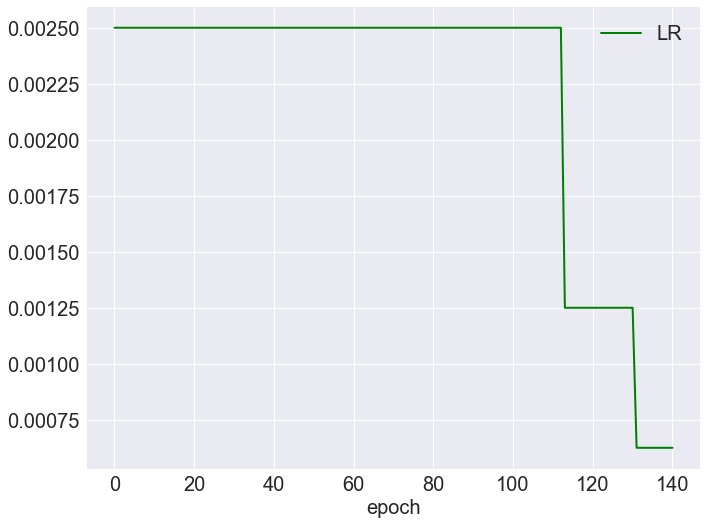

Saved model to disk


<Figure size 576x396 with 0 Axes>

In [105]:
    PlotHistory(loss_history)
    # Loss and accuracy
    trainKeys = [key for key in history.history.keys() if not 'val' in key]
    valKeys   = [key for key in history.history.keys() if 'val' in key]
    #plt.style.use('seaborn')
    print(history.history.keys())
    plt.figure(figsize=(11, 8.5))
    plt.grid(True)
    plt.plot(history.history.get('loss'),'g-',linewidth=2)
    plt.plot(history.history.get('val_loss'),'r-',linewidth=2)
    plt.legend(['Train loss', 'Validation loss'], 
                loc='best',ncol=2,fontsize=20)
    plt.xlabel('epoch',fontsize=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.savefig(os.path.join(tagdir,'Loss.png'), dpi=300)
    plt.show()
    plt.clf()

    plt.figure(figsize=(11, 8.5))
    plt.grid(True)
    plt.plot(history.history.get('categorical_accuracy'),'g-',linewidth=2)
    plt.plot(history.history.get('val_categorical_accuracy'),'r-',linewidth=2)
    plt.legend(['Train accuracy', 'Validation accuracy'], 
                loc='best',ncol=2,fontsize=20)
    plt.xlabel('epoch',fontsize=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.savefig(os.path.join(tagdir,'Accuracy.png'), dpi=300)
    plt.show()
    plt.clf()
    
    plt.figure(figsize=(11, 8.5))
    plt.grid(True)
    plt.plot(history.history.get('lr'),'g-',linewidth=2)
    plt.legend(['LR'],loc='best',fontsize=20)
    plt.xlabel('epoch',fontsize=20)
    plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.savefig(os.path.join(tagdir,'LR.png'), dpi=300)
    plt.show()
    plt.clf()

    model_json = model.to_json()
    with open(os.path.join(tagdir,"DNN_model.json"), "w") as jfile:
        jfile.write(model_json)
    model.save_weights(os.path.join(tagdir,"DNN_model.h5"))
    print("Saved model to disk")


In [106]:
def figure_lbn_weights(weights, name, norm=False, path="", cmap="OrRd", inp_particle_names=None, **fig_kwargs):
    # normalize weight tensor to a sum of 100 per row
    if norm:
        weights = np.abs(weights)
        weights = weights / np.sum(weights, axis=0).reshape((1, weights.shape[1])) * 100

    # create the figure
    #ph, pv = weights.shape
    #fig, ax = plt.subplots(1, 1, figsize=((pv + 1) // 2, (ph + 1) // 2))
    fig, ax = plt.subplots(1, 1, figsize=(11,6))
    ax.grid(False)
    # create and style the plot
    ax.imshow(weights, cmap=cmap, vmin=0, vmax=100, origin="lower")
    ax.set_title(f"{name} weights", fontdict={"fontsize": 16})

    ax.set_xlabel(f"LBN {name} number", fontdict={"fontsize": 16})
    ax.set_xticks(list(range(weights.shape[1])))

    ax.set_ylabel("Input particle", fontdict={"fontsize": 16})
    ax.set_yticks(list(range(weights.shape[0])))
    if inp_particle_names:
        ax.set_yticklabels(inp_particle_names, fontdict={"fontsize": 16})

    # write weights into each bin
    for (i, j), val in np.ndenumerate(weights):
        ax.text(j, i, int(round(weights[i, j])), fontsize=13, ha="center", va="center", color="k")

    return fig

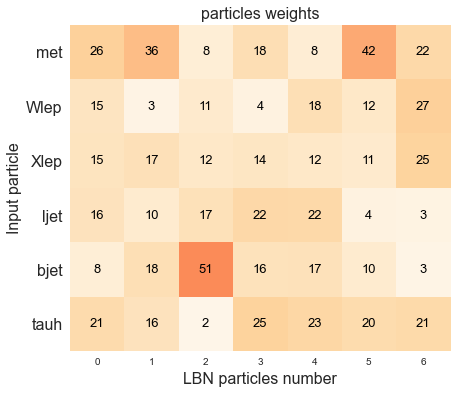

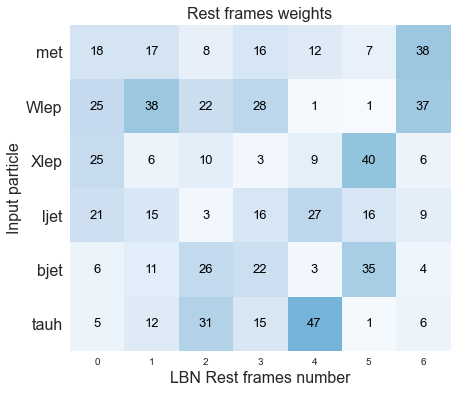

In [107]:
fig = figure_lbn_weights(lbn_layer_.weights[0], norm=True, name="particles", 
                         inp_particle_names=['tauh','bjet','ljet','Xlep','Wlep','met'],cmap="OrRd")
fig.show()
fig2 = figure_lbn_weights(lbn_layer_.weights[1], norm=True, name="Rest frames",
                          inp_particle_names=['tauh','bjet','ljet','Xlep','Wlep','met'], cmap="Blues")
fig2.show()

In [101]:
lbn_layer_.particle_weights

<tf.Variable 'LBN/variables/particle_weights:0' shape=(6, 12) dtype=float32, numpy=
array([[-0.02306416, -0.03756362,  0.0549636 ,  0.00837667, -0.00301572,
        -0.05820661, -0.02639364, -0.07461168, -0.08807879, -0.19293092,
         0.05271779,  0.09093776],
       [ 0.0202808 ,  0.3050395 , -0.07389201,  0.01101497,  0.08800022,
         0.05518974, -0.08504121, -0.07646216,  0.13976055,  0.04958868,
         0.049503  , -0.02021709],
       [-0.01309601, -0.06734908,  0.05645316, -0.22800863, -0.08957046,
        -0.07172972, -0.12898827,  0.14232345,  0.07455228,  0.14083973,
         0.1234875 ,  0.09463745],
       [-0.08340403,  0.01046128,  0.00683091, -0.07115358, -0.0464722 ,
        -0.02589012,  0.09543839,  0.14511341,  0.02050989, -0.14110667,
         0.0728941 ,  0.0467903 ],
       [-0.01592504, -0.01578945,  0.05027712,  0.04887357, -0.0049318 ,
        -0.02548428, -0.02106221,  0.00241051,  0.02324593,  0.06354993,
        -0.00279257,  0.14410996],
       [-0.

prediction probabilities for test dataset :
 [[0.4078258  0.5921743 ]
 [0.4055311  0.5944689 ]
 [0.44216636 0.5578337 ]
 ...
 [0.8855163  0.11448377]
 [0.65810823 0.34189183]
 [0.94984776 0.05015225]]
y_test : 
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
y_predication :
 [1 1 1 ... 0 0 0]
y_true :
 [1 1 1 ... 0 0 0]


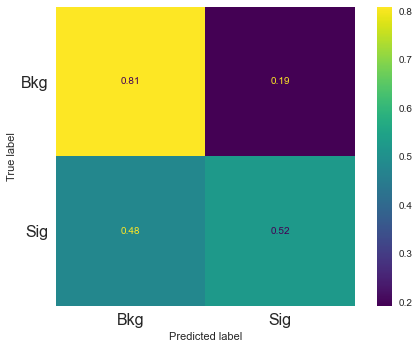

<Figure size 576x396 with 0 Axes>

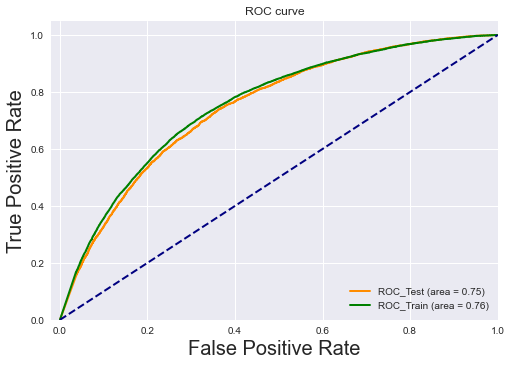

In [108]:
fit_test = np.hsplit(x_test,x_test.shape[1])
fit_test.append(x_test_lbn)

score_train   = model.predict(fit_inputs)
score_test    = model.predict(fit_test)

print(f'prediction probabilities for test dataset :\n {score_test}')
y_predProbaNoCutOnProb = score_test[:,-1]
y_predClassNoCutOnProb = np.asarray([np.argmax(item) for item in score_test])
y_true                 = y_test[:,-1].astype(int)
y_predProbaNoCutOnProbTrain = score_train[:,-1]
y_predClassNoCutOnProbTrain = np.asarray([np.argmax(item) for item in score_train])
y_trueTrain                 = y_train[:,-1].astype(int)
print(f'y_test : \n {y_test}')
print(f'y_predication :\n {y_predClassNoCutOnProb}')
print(f'y_true :\n {y_true}')
cnf_matrix = confusion_matrix(y_true, y_predClassNoCutOnProb, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)
disp.plot()
plt.grid(False)
plt.xticks(ticks=[1,0], labels=['Sig','Bkg'], fontsize=16)
plt.yticks(ticks=[1,0], labels=['Sig','Bkg'], fontsize=16)
plt.show()
plt.savefig(os.path.join(tagdir,'conf_matrix.png'), dpi=300)
plt.clf()

fpr_t, tpr_t, _ = roc_curve(y_trueTrain, y_predProbaNoCutOnProbTrain)
fpr, tpr, _ = roc_curve(y_true, y_predProbaNoCutOnProb)
roc_auc_t = auc(fpr_t, tpr_t)
roc_auc = auc(fpr, tpr)
#xgb.plot_importance(gbm)
#plt.show()
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC_Test (area = %0.2f)' % roc_auc)
plt.plot(fpr_t, tpr_t, color='green',
         lw=lw, label='ROC_Train (area = %0.2f)' % roc_auc_t)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',size=20)
plt.ylabel('True Positive Rate',size=20)
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.savefig(os.path.join(tagdir,'ROC.png'), dpi=300)
plt.show()